# PyTorch Workflow

In [1]:
learning = {1: "Data (prepare and load",
            2: "build model",
            3: "fitting the model to data (training)",
            4: "making prediction and evaluating the model (inference)",
            5: "saving and loading a model",
            6: "putting it all together"}
learning

{1: 'Data (prepare and load',
 2: 'build model',
 3: 'fitting the model to data (training)',
 4: 'making prediction and evaluating the model (inference)',
 5: 'saving and loading a model',
 6: 'putting it all together'}

In [22]:
import torch
from torch import nn
import matplotlib.pyplot as plt
import numpy as np

# Checking versions
torch.__version__

'2.9.1+cu128'

# 1. Data (preparing and loading)

Data can be almost anything… in machine learning.

- Excel spreadsheet  
- Images of any kind  
- Videos (YouTube has lots of data…)  
- Audio like songs or podcasts  
- DNA  
- Text  

## Machine learning is a game of two parts:

1. Get data into a numerical representation.  
2. Build a model to learn patterns in that numerical representation.


In [3]:
weight = 0.7
bias = 0.3

start = 0
end = 1
step = 0.02

X = torch.arange(start,end,step).unsqueeze(dim=1)
y = weight * X + bias

X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [4]:
len(X), len(y)

(50, 50)

### Splitting the data into training and test set

In [5]:
train_split = int(0.8 * len(X))

X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

In [6]:
def plot_prediction(train_data = X_train,
                    train_label = y_train,
                    test_data = X_test,
                    test_label = y_test,
                    prediction = None):

    plt.figure(figsize=(10, 7))
    
    #training data in blue
    plt.scatter(train_data, train_label, c="b", s=4, label="Training data")
    #testing data in green
    plt.scatter(test_data, test_label, c="g", s=4, label="Testing data")

    #predicition
    
    if prediction is not None:
        plt.plot(test_data, prediction, c="r", label="Prediction")

    plt.legend(prop={"size" :4})

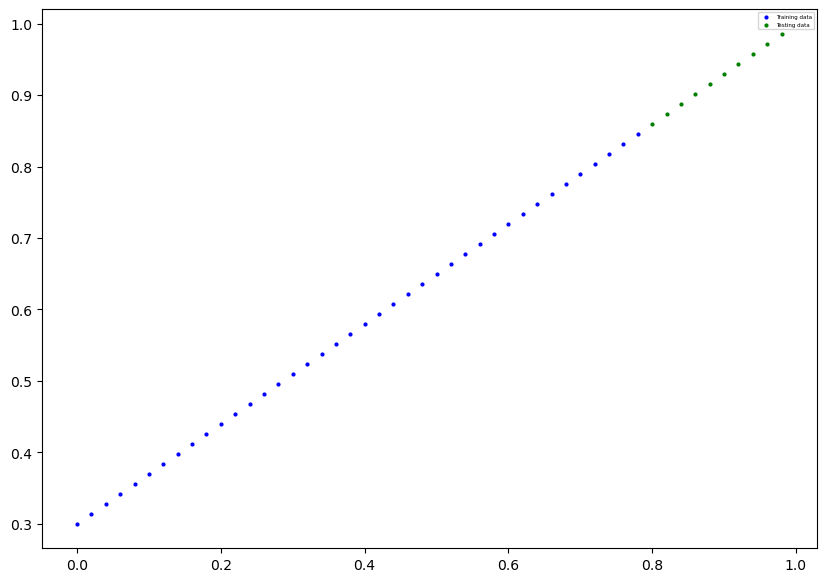

In [7]:
plot_prediction()

# 2. Building model

In [8]:
# Creating linear regression model class
class LinearRegressionModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(1,
                                                requires_grad=True,
                                                dtype = torch.float))
        
        self.bias = nn.Parameter(torch.randn(1,
                                             requires_grad=True,
                                             dtype = torch.float))

    # forward method to define the computation in the model
    def forward(self, x: torch.tensor) -> torch.tensor:
        return self.weights * x + self.bias

## PyTorch model building essentials

- **`torch.nn`**  
  Contains all of the building blocks for computational graphs  
  (a neural network can be considered a computational graph).

- **`torch.nn.Parameter`**  
  Defines what parameters our model should try and learn.  
  Often, a PyTorch layer from `torch.nn` will create these for us.

- **`torch.nn.Module`**  
  The base class for all neural network modules.  
  If you subclass it, you should override `forward()`.

- **`torch.optim`**  
  Where the optimizers in PyTorch live.  
  They help perform gradient descent.

- **`def forward()`**  
  All `nn.Module` subclasses must override `forward()`.  
  This method defines what happens in the forward computation.


# Checking the content of the model 

In [54]:
torch.manual_seed(42)

# create an instance of a model
model_0 = LinearRegressionModel()

# Checking the parameters
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [55]:
# List named parameter
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

In [56]:
weight, bias

(0.7, 0.3)

### Making predictions using `torch.inference_mode()` 

In [57]:
# Make predictions with model
with torch.inference_mode():
    y_pred = model_0(X_test)

y_pred

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])

In [58]:
y_test

tensor([[0.8600],
        [0.8740],
        [0.8880],
        [0.9020],
        [0.9160],
        [0.9300],
        [0.9440],
        [0.9580],
        [0.9720],
        [0.9860]])

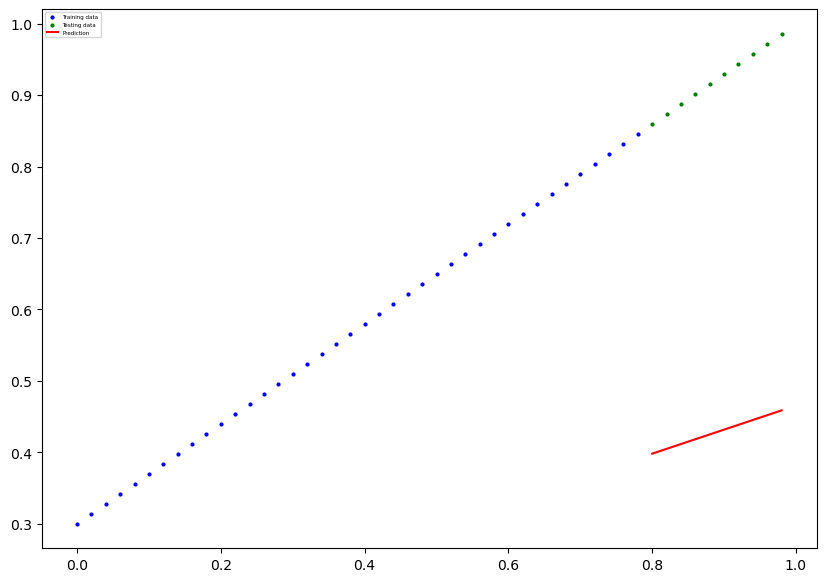

In [59]:
plot_prediction(prediction= y_pred)

# 3. Training Model

In [60]:
# Setup a loss function 
loss_fn = nn.L1Loss()

# Setup a optimizer
optimizer = torch.optim.SGD(params = model_0.parameters(),
                            lr = 0.01)  # Learning rate

# Building a training loop (and a testing loop) in PyTorch

A couple of things we need in a training loop:

0. **Loop through the data**
1. **Forward pass**  
   This involves data moving through our model’s `forward()` functions to make predictions on data — also called **forward propagation**.
2. **Calculate the loss**  
   Compare forward pass predictions to ground truth labels.
3. **Optimizer zero grad**
4. **Loss backward**  
   Move backwards through the network to calculate the gradients of each of the parameters of our model with respect to the loss (**backpropagation**).
5. **Optimizer step**  
   Use the optimizer to adjust our model’s parameters to try and improve the loss (**gradient descent**).


In [61]:
torch.manual_seed(42)


# an epoch is one loop through the data
epochs = 200

epoch_count = []
loss_value = []
test_loss_value = []

for epoch in range(epochs):
    model_0.train() # train mode in pytorch sets all parmeters that require parameters to require gradients

    # 1. Forward pass
    y_pred = model_0(y_train)

    # 2. Calculate the loss
    loss = loss_fn(y_pred, y_train)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Perform back propogation on the loss with respect to parameters of the model
    loss.backward()
    
    # 5. Step the optimzer (perform gradient descent)
    optimizer.step()

    # Testing
    model_0.eval() # Turn off different settings not needed for evaluation
    with torch.inference_mode():
        # Do the forward pass
        test_pred = model_0(X_test)

        # Calculate the loss
        test_loss = loss_fn(test_pred, y_test)
    if epoch % 10 == 0:  
        epoch_count.append(epoch)
        loss_value.append(loss)
        test_loss_value.append(test_loss)
        print(f"epoch: {epoch} | Loss: {loss} | Test Loss: {test_loss}")

        print(model_0.state_dict())

epoch: 0 | Loss: 0.2512670159339905 | Test Loss: 0.479436457157135
OrderedDict([('weights', tensor([0.3424])), ('bias', tensor([0.1388]))])
epoch: 10 | Loss: 0.13046450912952423 | Test Loss: 0.3380664885044098
OrderedDict([('weights', tensor([0.3973])), ('bias', tensor([0.2313]))])
epoch: 20 | Loss: 0.0869905948638916 | Test Loss: 0.25619304180145264
OrderedDict([('weights', tensor([0.4354])), ('bias', tensor([0.2793]))])
epoch: 30 | Loss: 0.0766981989145279 | Test Loss: 0.21701467037200928
OrderedDict([('weights', tensor([0.4592])), ('bias', tensor([0.2973]))])
epoch: 40 | Loss: 0.0736735463142395 | Test Loss: 0.19929786026477814
OrderedDict([('weights', tensor([0.4752])), ('bias', tensor([0.3008]))])
epoch: 50 | Loss: 0.07192783802747726 | Test Loss: 0.19062843918800354
OrderedDict([('weights', tensor([0.4877])), ('bias', tensor([0.2983]))])
epoch: 60 | Loss: 0.07044574618339539 | Test Loss: 0.18574944138526917
OrderedDict([('weights', tensor([0.4988])), ('bias', tensor([0.2933]))])


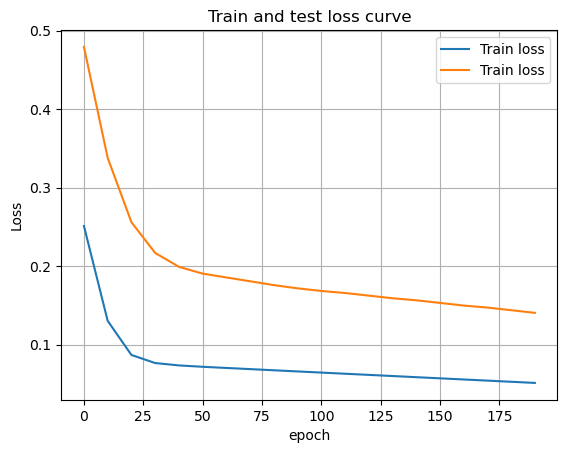

In [62]:
plt.plot(epoch_count, torch.tensor(loss_value).numpy(), label= "Train loss")
plt.plot(epoch_count, np.array(torch.tensor(test_loss_value).numpy()), label= "Train loss")
plt.title("Train and test loss curve")
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid()

In [63]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.6451])), ('bias', tensor([0.2103]))])

In [64]:
weight, bias

(0.7, 0.3)

In [65]:
with torch.inference_mode():    # Turns off gradient tracking
    y_pred_new = model_0(X_test)

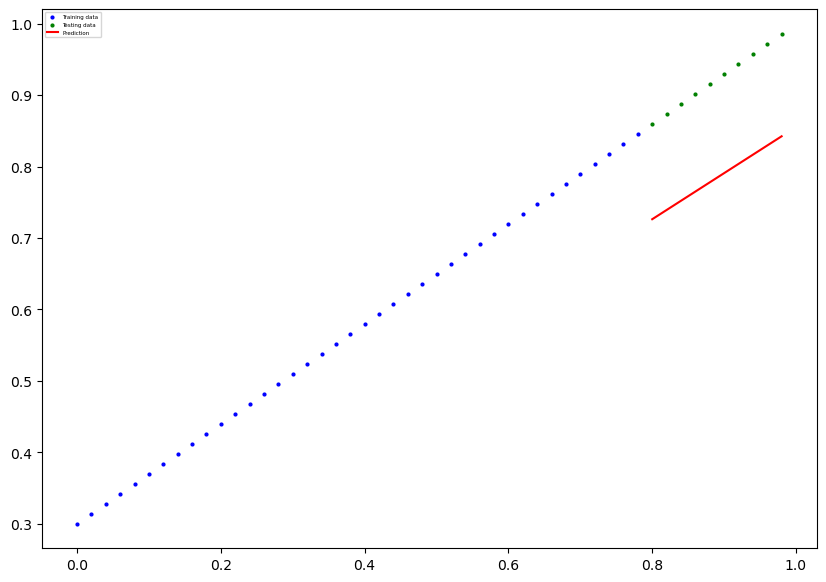

In [66]:
plot_prediction(prediction= y_pred_new);